In [ ]:
import os
import numpy as np
from datetime import datetime
import dill
import torch
from torch import nn
import torch.nn.functional as F
import lovely_tensors as lt
lt.monkey_patch()

import csng
from csng.utils.mix import seed_all, check_if_data_zscored
from csng.utils.data import standardize, normalize, crop
from csng.utils.comparison import find_best_ckpt, load_decoder_from_ckpt, plot_reconstructions, plot_metrics, eval_decoder
from csng.losses import get_metrics
from csng.data import get_dataloaders, get_sample_data

### set paths
DATA_PATH = os.environ["DATA_PATH"]
DATA_PATH_CAT_V1 = os.path.join(DATA_PATH, "cat_V1_spiking_model", "50K_single_trial_dataset")
DATA_PATH_MOUSE_V1 = os.path.join(DATA_PATH, "mouse_v1_sensorium22")
DATA_PATH_BRAINREADER = os.path.join(DATA_PATH, "brainreader")

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches
from csng.utils.comparison import autolabel

def plot_metrics(runs_to_compare, losses_to_plot, bar_width=0.8, save_to=None):
    sns.set_style("whitegrid")
    c_palette = sns.color_palette("tab10", n_colors=len(losses_to_plot))

    num_methods = len(runs_to_compare)
    num_metrics = len(losses_to_plot)

    fig_width = max(5, num_methods * (num_metrics // 2 + 1))
    fig_height = max(5, num_metrics * 1.5)

    k = list(runs_to_compare.keys())[0]
    for run_idx in range(len(runs_to_compare[k]["test_losses"])):
        fig, ax = plt.subplots(figsize=(fig_width, fig_height))

        index = np.arange(num_methods)
        bar_spacing = bar_width / num_metrics

        for i, (method, run_dict) in enumerate(runs_to_compare.items()):
            for j, loss_name in enumerate(losses_to_plot):
                value = run_dict["test_losses"][run_idx]["total"].get(loss_name, 0)
                rects = ax.bar(
                    i - bar_width / 2 + j * bar_spacing,
                    value,
                    width=bar_spacing,
                    color=c_palette[j],
                    label=loss_name if i == 0 else ""
                )

                # min_loss = min(
                #     runs_to_compare[_k]["test_losses"][run_idx]["total"].get(loss_name, float('inf'))
                #     for _k in runs_to_compare.keys()
                # )
                # is_lowest = value == min_loss
                # autolabel(ax, rects, fontsize=12, bold=is_lowest)
                autolabel(ax, rects, fontsize=12, bold=False)

        ax.set_xticks(index)
        ax.set_xticklabels(runs_to_compare.keys(), rotation=45, ha="right")
        ax.set_xlabel("Method", fontsize=14)
        # ax.set_ylabel("Value", fontsize=14)
        ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=num_metrics, frameon=False, fontsize=12)

        ax.yaxis.grid(True, alpha=0.4)
        ax.xaxis.grid(False)
        sns.despine()
        plt.tight_layout()
        plt.show()

        if save_to:
            fig.savefig(save_to, bbox_inches="tight")

        plt.close(fig)


In [4]:
runs_to_compare = torch.load("/home/jan/Desktop/Dev/csng/decoding-brain-activity/results/test/2025-02-14_22-55-41.pt", pickle_module=dill)
runs_to_compare.keys()

dict_keys(['runs', 'config'])

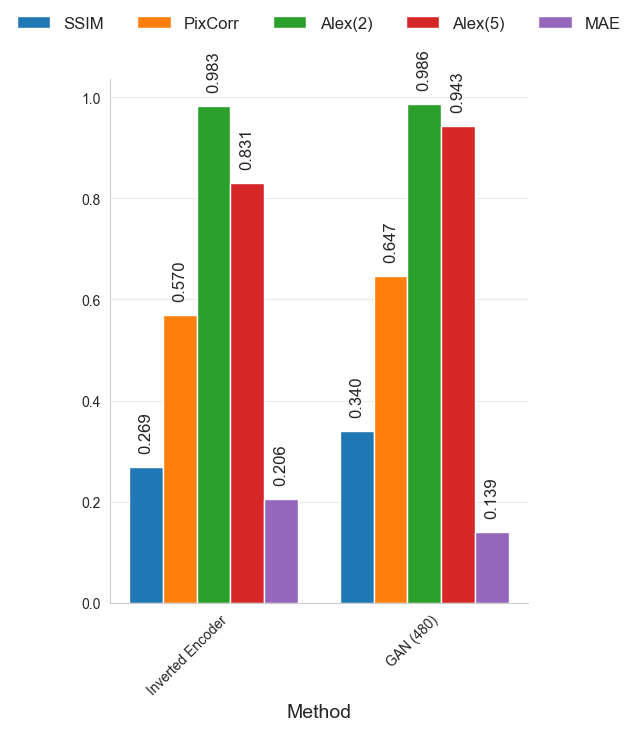

In [46]:
plot_metrics(
    runs_to_compare=runs_to_compare["runs"],
    losses_to_plot=[
        "SSIM",
        "PixCorr",
        "Alex(2)",
        "Alex(5)",
        "MAE",
        # "PL",
    ],
    # save_to=os.path.join(cfg["comparison"]["save_dir"], f"metrics.{f_type}") \
    #     if cfg["comparison"]["save_dir"] else None,
)